In [11]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt


# Load the datasets
customers_df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/customers_final.csv')
engagements_df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/engagements_final.csv')
marketing_df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/marketing_final.csv')
transactions_df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/transactions_final.csv')

## DATA CLEANING
# Convert date columns to datetime
customers_df['join_date'] = pd.to_datetime(customers_df['join_date'])
customers_df['last_purchase_date'] = pd.to_datetime(customers_df['last_purchase_date'])
marketing_df['campaign_date'] = pd.to_datetime(marketing_df['campaign_date'])
transactions_df['transaction_date'] = pd.to_datetime(transactions_df['transaction_date'])

# Define the cutoff date
cutoff_date = pd.to_datetime('2024-05-31')

# Convert dates later than 5/31/2024 to 5/31/2024
customers_df['join_date'] = customers_df['join_date'].apply(lambda x: x if x <= cutoff_date else cutoff_date)
customers_df['last_purchase_date'] = customers_df['last_purchase_date'].apply(lambda x: x if x <= cutoff_date else cutoff_date)
marketing_df['campaign_date'] = marketing_df['campaign_date'].apply(lambda x: x if x <= cutoff_date else cutoff_date)
transactions_df['transaction_date'] = transactions_df['transaction_date'].apply(lambda x: x if x <= cutoff_date else cutoff_date)

# Aggregate marketing responses
marketing_agg = marketing_df.groupby('customer_id')['response'].value_counts().unstack(fill_value=0).reset_index()
marketing_agg.columns = ['customer_id', 'no_response', 'yes_response']

# Aggregate transaction data
transactions_agg = transactions_df.groupby('customer_id').agg(
    total_transaction_amount=pd.NamedAgg(column='transaction_amount', aggfunc='sum'),
    number_of_transactions=pd.NamedAgg(column='transaction_id', aggfunc='count')
).reset_index()

# Merge all dataframes
merged_df = customers_df.merge(engagements_df, on='customer_id', how='left') \
                        .merge(marketing_agg, on='customer_id', how='left') \
                        .merge(transactions_agg, on='customer_id', how='left')

# Fill NaN values for no_response and yes_response with 0
merged_df['no_response'] = merged_df['no_response'].fillna(0)
merged_df['yes_response'] = merged_df['yes_response'].fillna(0)

# Fill NaN values for total_transaction_amount and number_of_transactions with 0
merged_df['total_transaction_amount'] = merged_df['total_transaction_amount'].fillna(0)
merged_df['number_of_transactions'] = merged_df['number_of_transactions'].fillna(0)

# Impute 'Unknown' for missing gender values
merged_df['gender'] = merged_df['gender'].fillna('Unknown')

# Impute missing age with KNNImputer
# Convert date columns to numeric
merged_df['join_date_numeric'] = merged_df['join_date'].astype('int64') // 10**9
merged_df['last_purchase_date_numeric'] = merged_df['last_purchase_date'].astype('int64') // 10**9

# Encode categorical variables
le_gender = LabelEncoder()
merged_df['gender_encoded'] = le_gender.fit_transform(merged_df['gender'])

le_location = LabelEncoder()
merged_df['location_encoded'] = le_location.fit_transform(merged_df['location'])

# Prepare data for KNN imputation
impute_cols = ['age', 'join_date_numeric', 'last_purchase_date_numeric', 'gender_encoded', 'location_encoded']
impute_data = merged_df[impute_cols]

# Perform KNN imputation
knn_imputer = KNNImputer(n_neighbors=5)
imputed_data = knn_imputer.fit_transform(impute_data)

# Assign imputed age values back to the dataframe
merged_df['age'] = imputed_data[:, 0]

# Drop intermediate columns
merged_df = merged_df.drop(columns=['join_date_numeric', 'last_purchase_date_numeric', 'gender_encoded', 'location_encoded'])

## Feature Engineering

# Calculate Recency, Frequency, and Monetary (clv_monthly) Value (RFM) features
# Define the cutoff date
cutoff_date = pd.to_datetime('2024-06-01')

# Calculate the joined month
merged_df['joined_month'] = ((cutoff_date - merged_df['join_date']).dt.days / 30).astype(int)
merged_df['joined_month'] = merged_df['joined_month'].apply(lambda x: 1 if x == 0 else x)

# Calculate Recency (in months)
merged_df['recency_months'] = ((cutoff_date - merged_df['last_purchase_date']).dt.days / 30).astype(int)

# Calculate Frequency
merged_df['frequency'] = merged_df['number_of_transactions']

# Calculate Monetary Value (transaction value per month, clv_monthly)
merged_df['clv_monthly'] = merged_df['total_transaction_amount'] / merged_df['joined_month']

# Fill any NaN values resulting from zero transactions or other calculations
merged_df['recency_months'] = merged_df['recency_months'].fillna(0)
merged_df['frequency'] = merged_df['frequency'].fillna(0)
merged_df['clv_monthly'] = merged_df['clv_monthly'].fillna(0)

# For marketing and engagement data
# Calculate the number of 'yes_response' per transaction
merged_df['yes_response_per_transaction'] = merged_df['yes_response'] / merged_df['number_of_transactions']

# Calculate the number of 'no_response' per transaction
merged_df['no_response_per_transaction'] = merged_df['no_response'] / merged_df['number_of_transactions']

# Calculate the number of site visits per transaction
merged_df['site_visits_per_transaction'] = merged_df['number_of_site_visits'] / merged_df['number_of_transactions']

# Calculate the number of emails opened per transaction
merged_df['emails_opened_per_transaction'] = merged_df['number_of_emails_opened'] / merged_df['number_of_transactions']

# Calculate the number of clicks per transaction
merged_df['clicks_per_transaction'] = merged_df['number_of_clicks'] / merged_df['number_of_transactions']

# use the 80-20 rule, sorting the customer with clv_monthly
# labelling the highest clv_monthly customers who cumulatively contribute 80% of the total monthly clv as 'High-Value'
# other as ‘Low-Value’

# Calculate the cumulative contribution of each customer to the total monthly CLV
merged_df = merged_df.sort_values(by='clv_monthly', ascending=False)
merged_df['cumulative_clv'] = merged_df['clv_monthly'].cumsum()
total_clv = merged_df['clv_monthly'].sum()
merged_df['cumulative_clv_percentage'] = merged_df['cumulative_clv'] / total_clv

# Label customers based on their contribution to the total monthly CLV
merged_df['value_label'] = np.where(merged_df['cumulative_clv_percentage'] <= 0.80, 'High-Value', 'Low-Value')

# Convert CLV_label to binary
merged_df['value_label'] = np.where(merged_df['value_label'] == 'High-Value', 1, 0)

# Drop intermediate columns
merged_df = merged_df.drop(columns=['cumulative_clv', 'cumulative_clv_percentage'])

In [12]:
merged_df.head()

,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,no_response,...,joined_month,recency_months,frequency,clv_monthly,yes_response_per_transaction,no_response_per_transaction,site_visits_per_transaction,emails_opened_per_transaction,clicks_per_transaction,value_label
7015,7016,2024-05-14,2024-05-28,45.0,Unknown,West Karifort,6,1,1,1,...,1,0,25,22364.72,0.00,0.040000,0.240000,0.040000,0.040000,1
6632,6633,2024-05-25,2024-05-28,54.0,Male,Anthonymouth,1,1,1,3,...,1,0,25,21518.15,0.00,0.120000,0.040000,0.040000,0.040000,1
7583,7584,2024-04-20,2024-05-12,24.0,Female,Elizabethton,1,1,1,1,...,1,0,25,21056.06,0.04,0.040000,0.040000,0.040000,0.040000,1
8833,8834,2024-04-17,2024-04-22,40.0,Unknown,Georgehaven,1,1,1,1,...,1,1,23,17721.61,0.00,0.043478,0.043478,0.043478,0.043478,1
5825,5826,2024-05-20,2024-05-30,45.0,Male,Aprilport,4,1,1,1,...,1,0,25,17360.68,0.12,0.040000,0.160000,0.040000,0.040000,1


In [13]:
merged_df.describe()

,customer_id,join_date,last_purchase_date,age,number_of_site_visits,number_of_emails_opened,number_of_clicks,no_response,yes_response,total_transaction_amount,...,joined_month,recency_months,frequency,clv_monthly,yes_response_per_transaction,no_response_per_transaction,site_visits_per_transaction,emails_opened_per_transaction,clicks_per_transaction,value_label
count,10000.00000,10000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,2022-03-19 09:28:13.439999744,2023-04-25 18:26:12.480000,43.494460,100.111900,39.862100,19.725300,1.262200,1.257800,7737.562981,...,26.35620,12.931900,12.954500,810.852394,0.192833,0.192110,15.944076,6.300875,3.092276,0.273500
min,1.00000,2020-01-01 00:00:00,2020-01-26 00:00:00,18.000000,1.000000,1.000000,1.000000,0.000000,0.000000,23.810000,...,1.00000,0.000000,1.000000,0.580732,0.000000,0.000000,0.040000,0.040000,0.040000,0.000000
25%,2500.75000,2021-02-15 00:00:00,2022-09-19 00:00:00,31.350000,15.000000,6.000000,3.000000,1.000000,1.000000,3839.915000,...,13.00000,3.000000,7.000000,143.797857,0.041667,0.041667,1.320000,0.526316,0.291667,0.000000
50%,5000.50000,2022-03-19 00:00:00,2023-08-04 00:00:00,43.800000,53.000000,22.000000,11.000000,1.000000,1.000000,7498.890000,...,26.00000,10.000000,13.000000,293.639635,0.090909,0.090909,4.848077,2.000000,1.000000,0.000000
75%,7500.25000,2023-04-28 00:00:00,2024-02-11 00:00:00,55.000000,141.000000,57.000000,28.000000,2.000000,2.000000,11275.797500,...,40.00000,20.000000,19.000000,598.266364,0.187500,0.187500,14.000000,5.666667,2.764706,1.000000
max,10000.00000,2024-05-31 00:00:00,2024-05-31 00:00:00,69.000000,711.000000,303.000000,142.000000,4.000000,4.000000,24298.220000,...,53.00000,52.000000,25.000000,22364.720000,4.000000,4.000000,684.000000,298.000000,113.000000,1.000000
std,2886.89568,NaN,NaN,14.483754,118.625052,46.511719,22.975083,0.961532,0.971511,4628.799469,...,15.50841,11.742285,7.191203,1856.025090,0.361048,0.350781,39.410611,15.256806,7.251774,0.445778


C:\Users\NeilXu\AppData\Local\Temp\ipykernel_9720\11667304.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_clv_stats = merged_df.groupby(['age_group', 'value_label'])['clv_monthly'].agg(['median', 'mean']).reset_index()


  age_group  value_label       median         mean
0       <20            0   201.272509   220.186372
1       <20            1  1073.436571  2125.278714
2     20-40            0   214.871600   225.508101
3     20-40            1  1145.064359  2286.563045
4     40-60            0   208.524707   221.623977
5     40-60            1  1110.434286  2429.151094
6       >60            0   211.081861   222.718212
7       >60            1  1193.133810  2454.031236


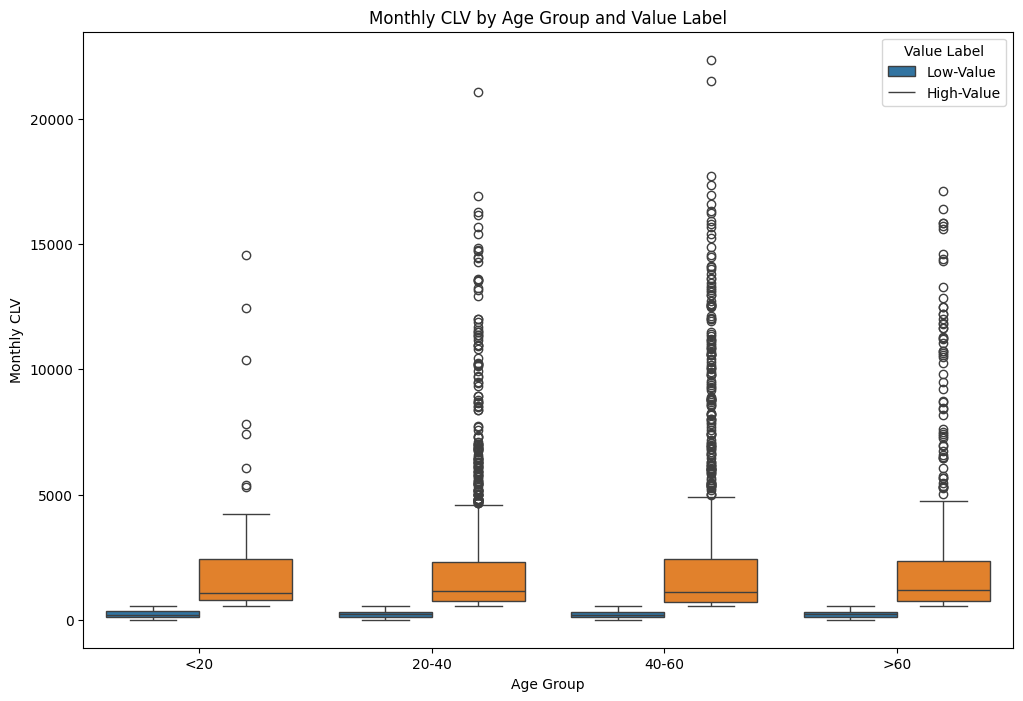

In [16]:
# age-clv analysis
# Define age groups
bins = [0, 20, 40, 60, np.inf]
labels = ['<20', '20-40', '40-60', '>60']
merged_df['age_group'] = pd.cut(merged_df['age'], bins=bins, labels=labels, right=False)

# Calculate median and mean of monthly CLV grouped by age and value label
age_clv_stats = merged_df.groupby(['age_group', 'value_label'])['clv_monthly'].agg(['median', 'mean']).reset_index()

print(age_clv_stats)

# Prepare data for boxplot
boxplot_data = merged_df[['age_group', 'value_label', 'clv_monthly']]

# Plotting
plt.figure(figsize=(12, 8))
sns.boxplot(x='age_group', y='clv_monthly', hue='value_label', data=boxplot_data)
plt.title('Monthly CLV by Age Group and Value Label')
plt.xlabel('Age Group')
plt.ylabel('Monthly CLV')
plt.legend(title='Value Label', labels=['Low-Value', 'High-Value'])
plt.show()

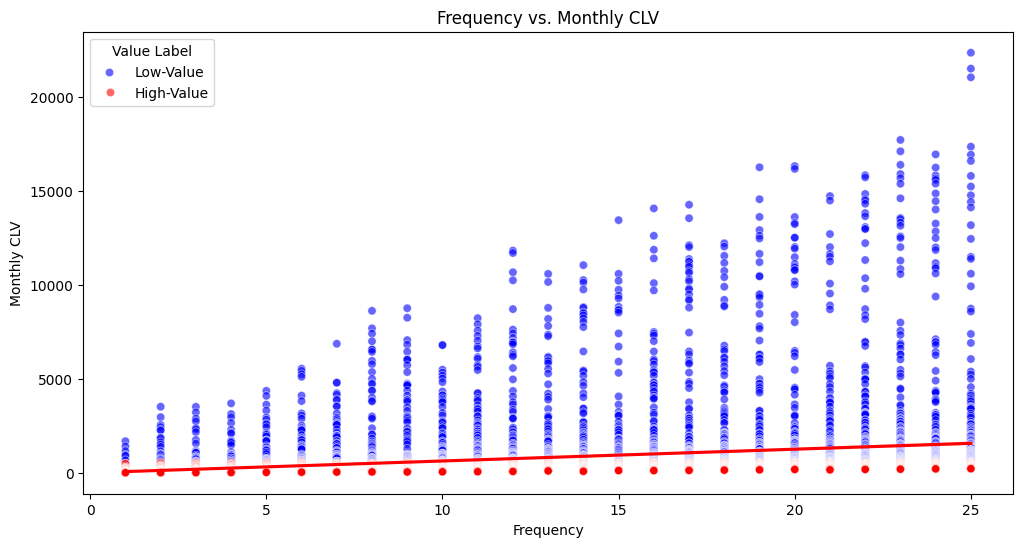

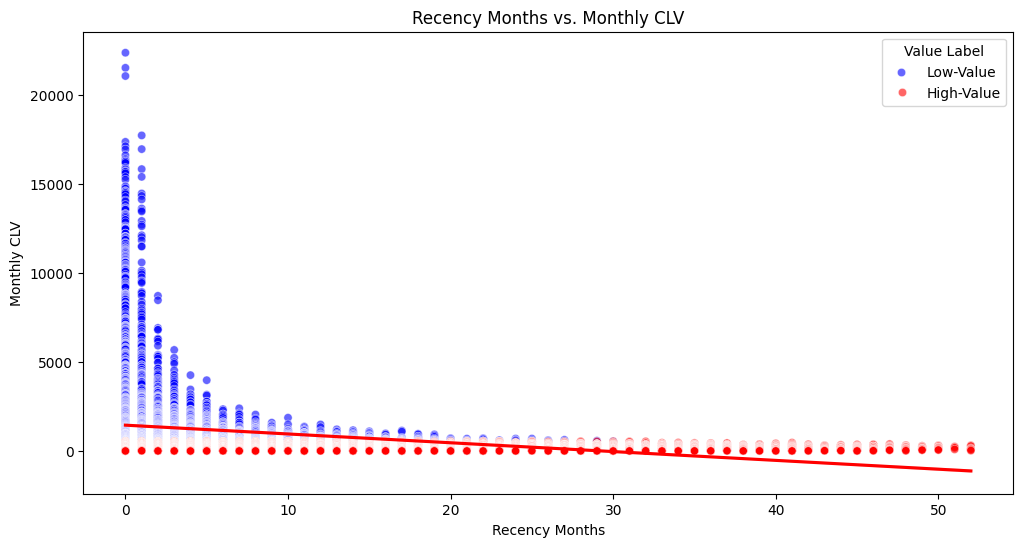

In [19]:
# Scatter plot: Frequency vs. Monthly CLV
plt.figure(figsize=(12, 6))
sns.scatterplot(data=merged_df, x='frequency', y='clv_monthly', hue='value_label', palette=['red', 'blue'], alpha=0.6)
sns.regplot(data=merged_df, x='frequency', y='clv_monthly', scatter=False, color='red')
plt.title('Frequency vs. Monthly CLV')
plt.xlabel('Frequency')
plt.ylabel('Monthly CLV')
plt.legend(title='Value Label', labels=['Low-Value', 'High-Value'])
plt.show()

# Scatter plot: Recency Months vs. Monthly CLV
plt.figure(figsize=(12, 6))
sns.scatterplot(data=merged_df, x='recency_months', y='clv_monthly', hue='value_label', palette=['red', 'blue'], alpha=0.6)
sns.regplot(data=merged_df, x='recency_months', y='clv_monthly', scatter=False, color='red')
plt.title('Recency Months vs. Monthly CLV')
plt.xlabel('Recency Months')
plt.ylabel('Monthly CLV')
plt.legend(title='Value Label', labels=['Low-Value', 'High-Value'])
plt.show()

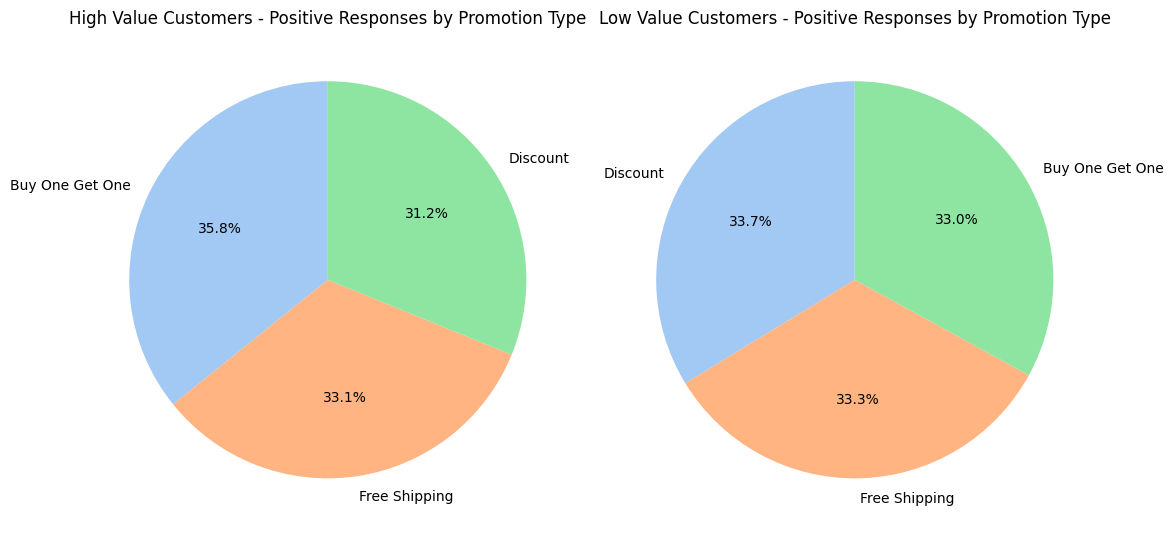

In [21]:
# EDA response type
# Filter high value and low value customers
high_value_customers = merged_df[merged_df['value_label'] == 1]['customer_id']
low_value_customers = merged_df[merged_df['value_label'] == 0]['customer_id']

# Filter marketing data for high value and low value customers
high_value_marketing = marketing_df[marketing_df['customer_id'].isin(high_value_customers) & (marketing_df['response'] == 'Yes')]
low_value_marketing = marketing_df[marketing_df['customer_id'].isin(low_value_customers) & (marketing_df['response'] == 'Yes')]

# Count positive responses for each promotion type
high_value_promotion_counts = high_value_marketing['promotion_type'].value_counts()
low_value_promotion_counts = low_value_marketing['promotion_type'].value_counts()

# Plot pie chart for high value customers
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
high_value_promotion_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('High Value Customers - Positive Responses by Promotion Type')
plt.ylabel('')

# Plot pie chart for low value customers
plt.subplot(1, 2, 2)
low_value_promotion_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Low Value Customers - Positive Responses by Promotion Type')
plt.ylabel('')

plt.tight_layout()
plt.show()

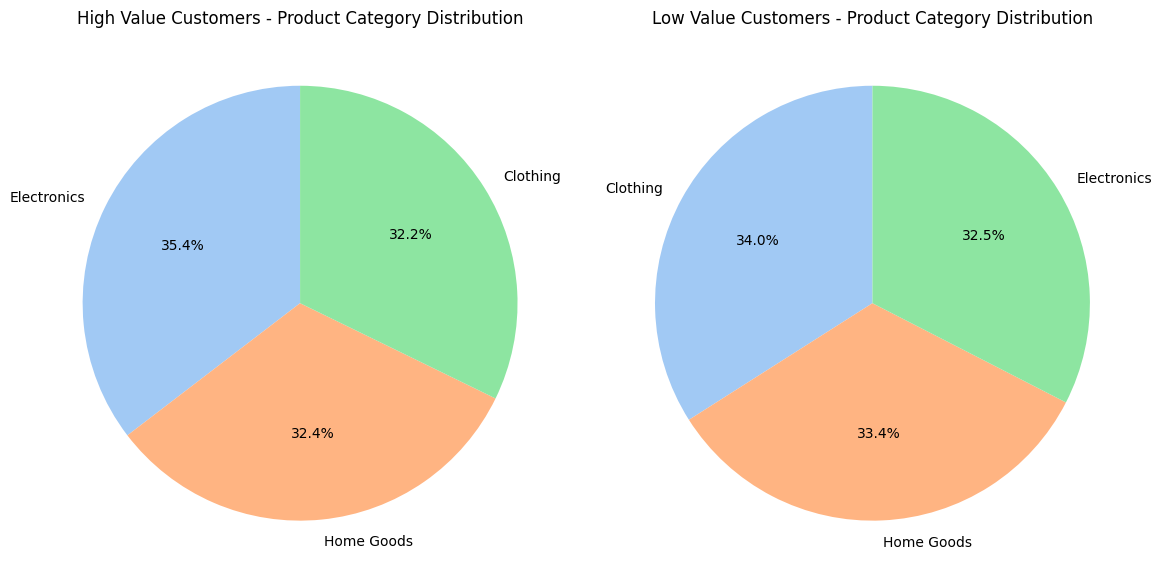

In [24]:
# Promotion type analysis
# Filter high value and low value customers
high_value_customers = merged_df[merged_df['value_label'] == 1]['customer_id']
low_value_customers = merged_df[merged_df['value_label'] == 0]['customer_id']

# Filter transaction data for high value and low value customers
high_value_transactions = transactions_df[transactions_df['customer_id'].isin(high_value_customers)]
low_value_transactions = transactions_df[transactions_df['customer_id'].isin(low_value_customers)]

# Count product categories for each customer group
high_value_product_counts = high_value_transactions['product_category'].value_counts()
low_value_product_counts = low_value_transactions['product_category'].value_counts()

# Plot pie chart for high value customers
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
high_value_product_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('High Value Customers - Product Category Distribution')
plt.ylabel('')

# Plot pie chart for low value customers
plt.subplot(1, 2, 2)
low_value_product_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Low Value Customers - Product Category Distribution')
plt.ylabel('')

plt.tight_layout()
plt.show()